<center><img src="https://i.imgur.com/c4TvLIg.png"/> </center>
<br>
<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1"> ⚡️ Зачем Lightning?  </a></li>
<li><a href="#c2"> 🤹 Подготовка библиотек и датасета (проматывай) </a></li>
<li><a href="#c3"> 🫣 Играем в игру: "Было - Стало" 🤗 </a></li>
<li><a href="#c4"> Основные компоненты PyTorch Lightning ⚡️ </a></li>
<li><a href="#c5">👆 DataModule = Dataset + Dataloader ✌️ </a></li>
<li><a href="#с6">🪚 Пилим нейронку c Lightning ⚡️ (стало)</a>
<li><a href="#c7">🧌 Не боги неройнки обучают - Trainer </a>
<li><a href="#c8">🩺 Отладка + Profiler 🎛</a>
<li><a href="#c9">🍏 Результаты и выводы ✅</a>
<li><a href="#c10">📝 Полезные ссылки </a>

</li></ul></font></p>

# <center id="c1"> ⚡️ Зачем Lightning? </center>

<div class="alert alert-info">

`Lightning` - целая экосистема фреймворков, которая нацелена на упрощение обучения моделей, их запуска и тд. В этом ноутбуке мы остановимся на `PyTorch Lightning` - модуль, который упрощает работу с библиотекой `PyTorch` и расширяет её.

<div class="alert alert-success">

⚡️ `PyTorch Lightning` - позволяет писать меньше рутинного кода: тренировочных и валидациооных циклов, механизмов **early_stopping**, сохранения моделей и пр. Вместо этого можно сосредоточиться на поиске идей и экспериментов. К тому же код будет легкочитаем и выглядеть компактно.

<img src="https://i.imgur.com/OlWeyt8.png"/>

<div class="alert alert-info">
    
`PyTorch Lightning` включает в себя *полный набор* для поддержания жизненного цикла модели 🤯 от тренировки до развертывания в продакшене: квантизация, прунинг, подбор гиперпараметров, логирование, отладка и много чего ещё. <br>

<div class="alert alert-info">
Чаще всего подключение новой функциональности занимает лишь пару строчек кода. 

In [1]:
# Установка Pytorch Lightning
!pip install lightning -q

<div class="alert alert-warning">

<p style="text-align: center;"> ВАЖНО! 👺 </p>

Если на каком-то ресурсе вы видите `pip install pytorch-lightning` - значит вы собираетесь использовать старое API 😯! Функции обратно совместимы, но их импорт может отличаться - будьте аккуратны и устанавливайте только свежие версии библиотек.

# <center id="c2"> 🤹 Подготовка библиотек и датасета (проматывай)

### <center> 📚 Импортируем библиотеки 

In [1]:
import copy
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split

from lightning import Trainer, LightningModule, LightningDataModule
from lightning.pytorch.callbacks import ModelSummary
import lightning.pytorch as pl

from typing import Tuple

In [3]:
# Для отображения схемы нейронки
!pip install torchview -q
import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

### <center> 🧪 Конфиг 


In [2]:
@dataclass
class CFG:
    seed: int = 2024
    device: str = "cuda"  # 'cpu'
    hidden_size: int = 128
    dropout: float = 0.1
    lr: float = 1e-3
    batch_size: int = 128
    num_workers: int = 4
    epochs: int = 20
    gpus: int = 2
cfg = CFG()

<div class="alert alert-info">
    
**Первая фишка** - не надо самим писать функцию по фиксированию всех возможных сидов, можно импортировать её из `Lightning` и не беспокоиться, что что-то забыли зафиксировать и результаты не воспроизведутся.

In [3]:
from lightning.pytorch import seed_everything

seed_everything(cfg.seed)

Seed set to 2024


2024

###  <center> 🍽 Подгружаем и готовим данные 

In [4]:
url = 'https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/quickstart_train.csv'
rides_info = pd.read_csv(url)
rides_info.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


In [5]:
# Проводим препроцессинг данных для старта обучения
drop_cols = ["car_id", "target_reg", "target_class"]
cat_cols = ["car_type", "fuel_type", "model"]
rides_info = pd.get_dummies(rides_info, columns=cat_cols)
rides_info.fillna(rides_info.median(numeric_only=True), inplace=True)
num_cols = [col for col in list(rides_info.columns) if col not in drop_cols]

In [6]:
# Нормализуем данные и кодируем таргет

scaler = RobustScaler()
le = LabelEncoder()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()
target = target_scaler.fit_transform(rides_info["target_reg"].values.reshape(-1, 1))

df["target_reg"] = target
df["target_class"] = le.fit_transform(rides_info["target_class"]).reshape((-1, 1))

In [7]:
# Разбиваем датасет на трэйн и тест выборки
train, test = train_test_split(df, test_size=0.2, random_state=cfg.seed)

cfg.num_features = train.shape[1] - 2  # количество фичей, подаваемое на вход
cfg.num_tar_class = (
    train.target_class.nunique()
)  # количество выходов равно количеству предсказываемых классов

In [8]:
df.head(3)

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,...,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,target_reg,target_class
0,-0.460317,0.5,0.258414,0.75,0.567305,-0.187985,0.0,0.129562,0.019027,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.022894,0
1,-0.365079,0.5,0.303616,0.75,0.072227,0.841243,-0.1,0.237381,1.085987,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.238877,2
2,1.539683,-1.0,-0.903502,-0.25,0.626258,0.465096,0.0,-1.077932,0.235335,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219438,7


# <center id="c3"> 🫣 Играем в игру: "Было - Стало" 🤗</center>

<div class="alert alert-info">
    
Рассмотрим уже знакомый код фрагментов по обучению двухголовой нейронки, перенесём код на `Lightning` и оценим эффект!

## <center> 🧠 Фрагменты архитектры нейронки на чистом `PyTorch` (было)

In [9]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]

        data = row.drop(labels=["target_reg", "target_class"])
        data = torch.FloatTensor(data.values.astype("float"))
        tar_reg = torch.tensor(row["target_reg"]).float()
        tar_class = row["target_class"].astype("int")

        return data, tar_reg, tar_class

In [10]:
train_datasets = {"train": Rides(train), "val": Rides(test)}

In [11]:
dataloaders_dict = {
    x: DataLoader(
        train_datasets[x],
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )
    for x in ["train", "val"]
}

### <center> 🕸 Сама нейросеть на `PyTorch`

In [12]:
class TabularNN(nn.Module): # Наследуемся от базового класса PyTorch
    def __init__(self, cfg):
        super().__init__()
        # Напишем простенькую нейронку
        self.mlp = nn.Sequential(
            nn.Linear(cfg.num_features, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.LeakyReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.GELU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
        )
        # Так как два таргета, делаем две головы - одна для регрессии, другая - классификации
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )

    def forward(self, data):
        x = self.mlp(data)
        tar_reg = self.regressor(x)
        tar_class = self.classifier(x)
        return tar_reg.view(-1), tar_class

In [13]:
model = TabularNN(cfg).to(cfg.device) # Отправляем сетку на GPU или CPU

In [14]:
# Задаем оптимизатор и два лосса - для разных таргетов
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
regression_criterion = nn.MSELoss().to(cfg.device)
classification_criterion = nn.CrossEntropyLoss().to(cfg.device)

### <center> 🥫 Консервативный `Train loop`, которого скоро не станет 🙅‍♀️

In [15]:
# Train LOOP 
def train_model(
    model,
    dataloaders,
    regression_criterion,
    classification_criterion,
    optimizer,
    num_epochs=25,
    early_stopping_rounds=5,
    verbose=2,
):

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    early_steps = 0
    stop = False

    for epoch in range(num_epochs):
        if stop:
            break
        if epoch % verbose == 0:
            print("Epoch {}/{}".format(epoch, num_epochs - 1))
            print("-" * 10)

        # В каждой эпохе учимся на train и валидируемся на val
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Обучаем модельку
            else:
                model.eval()  # Тестируем ее

            running_loss = 0.0

            for inputs, labels_1, labels_2 in dataloaders[phase]:
                inputs = inputs.to(cfg.device)
                labels_1 = labels_1.to(cfg.device)
                labels_2 = labels_2.to(cfg.device)

                optimizer.zero_grad()

                # Включаем градиенты только на этапе обучения
                with torch.set_grad_enabled(phase == "train"):
                    outputs_1, outputs_2 = model(inputs)
                    loss_1 = regression_criterion(outputs_1, labels_1)
                    loss_2 = classification_criterion(outputs_2, labels_2)

                    loss = loss_1 + loss_2

                    _, preds_2 = torch.max(outputs_2, 1)

                    # Распространим ошибку обратно
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                val_acc_history.append(running_loss)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if epoch % verbose == 0:
                print("{} Loss: {:.4f}".format(phase, epoch_loss))
            
            # Сохраняем только лучшую модель
            if phase == "val" and epoch_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
                early_steps = 0
            if phase == "val" and epoch_loss > best_loss:
                early_steps += 1
                if early_steps > early_stopping_rounds:
                    stop = True
                    print(f"Stopped by early_stopping. Epoch: {epoch}")
                    break

    # Подгружаем ее
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# И наконец обучаем!
model_ft = train_model(
    model,
    dataloaders_dict,
    regression_criterion,
    classification_criterion,
    optimizer,
    num_epochs=cfg.epochs,
)

Epoch 0/19
----------
train Loss: 2.7096
val Loss: 2.7237
Epoch 2/19
----------
train Loss: 2.2425
val Loss: 2.0766
Epoch 4/19
----------
train Loss: 1.6136
val Loss: 1.5752
Epoch 6/19
----------
train Loss: 1.3000
val Loss: 1.3404
Epoch 8/19
----------
train Loss: 1.1532
val Loss: 1.2237
Epoch 10/19
----------
train Loss: 1.0947
val Loss: 1.1968
Epoch 12/19
----------
train Loss: 1.0611
val Loss: 1.1537
Epoch 14/19
----------
train Loss: 1.0279
val Loss: 1.1425
Epoch 16/19
----------
train Loss: 1.0122
val Loss: 1.1527
Epoch 18/19
----------
train Loss: 0.9736
val Loss: 1.1391


In [17]:
del model, model_ft

<div class="alert alert-success" style="display: inline-block;">
    <img src="https://i.imgur.com/jEOxu9w.jpeg" align='right'>
Забываем неудобный код - потому что мы собираемся взлететь на Олимп c PyTorch Lightning ⚡️

# <center id="c4"> **Основные компоненты PyTorch Lightning ⚡️**  

<div class="alert alert-warning">

Добавить картиночку структуры внутри Lightning

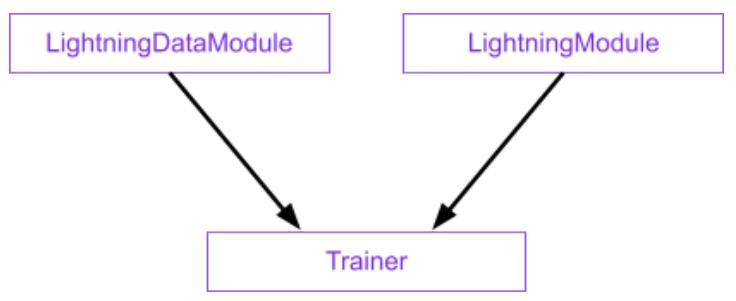

<div class="alert alert-info">

* `LightningModule` - наследник `nn.Module`, обязательные атрибуты такие же `__init__`, `forward`. Но внутри есть целое множество удобных методов, такие как `training_step`, `test_step`, которые рассмотрим далее.
  
* `Trainer` - функция обучения нейронки, внутри которой есть абсолютно **ВСЕ**: если захотели включить Early Stopping - добавили callback и все!
  
* `LightningDataModule` - наследник `Dataset`, но который может возвращать помимо `Dataset` еще и `Dataloader` и делать это сразу для train, test, valid частей - очень удобно!

# <center id="c5"> 👆 DataModule = Dataset + Dataloader ✌️ </center>

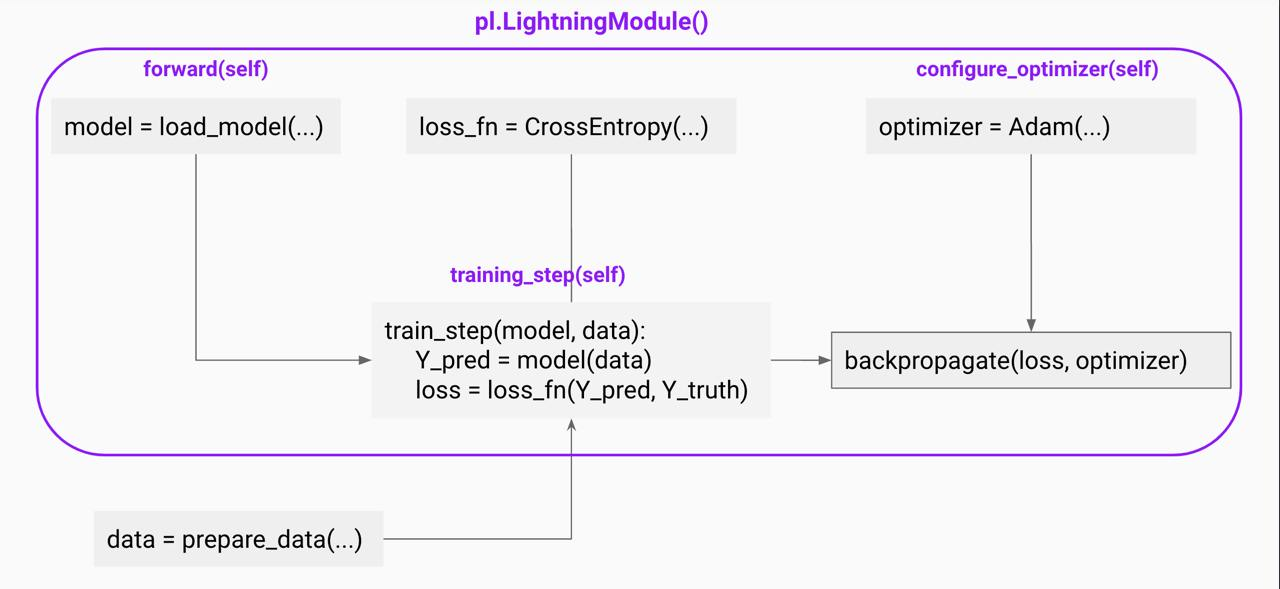

<div class="alert alert-success">

`LightningDataModule` — это класс из библиотеки `Lightning`, который предназначен для упрощения работы с данными в процессе обучения моделей. Он помогает организовать загрузку, предобработку и разделение данных на обучающие, валидационные и тестовые выборки. У него есть следующие методы:

- **`train_dataloader(), val_dataloader(), test_dataloader()`**: 
   - Метод, который возвращает `DataLoader` для `train`, `valid`, `test` частей соответсвенно

- **`prepare_data()`**: 
   - Метод, который отвечает за подготовку данных. Например загрузка датасета, токенизация текста, применение аугментаций и тд. Этот метод вызывается один раз и исполняется только на одном потоке и не может быть распараллелено 

- **`setup(stage)`**: 
    - Метод, который используется для разделения данных

In [18]:
# стало
class RidesLightning(LightningDataModule):
    def __init__(self, cfg: CFG, train_datasets: dict) -> None: 
        # Сохраняем переменные для дальнейшей работы
        super().__init__()

        self.cfg = cfg
        self.datasets = train_datasets

    def setup(self, stage: str):
        # Создаем Dataset'ы
        self.train = self.datasets["train"]
        self.val = self.datasets["val"]

    
    def _make_dataloader(self, dataset, cfg):
        # Общий метод для создания DataLoader
        return DataLoader(
            dataset,
            batch_size=self.cfg.batch_size,
            num_workers=self.cfg.num_workers,
            pin_memory=True
        )

    def train_dataloader(self):
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.train, cfg)
    
    def val_dataloader(self):
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.val, cfg)
    
    def teardown(self, stage: str):
        # Функция, которая выполняется после создания Dataloader - здесь можно удалить ненужные компоненты
        del self.train, self.val

<div class="alert alert-info">

`LightningDataModule` можно использовать и отдельно для ваших нужд, если вы хотите использовать `Dataset` из `Lightning`, а обучать модель на `PyTorch` 💀

In [19]:
# Проверим как выглядит один батч
dataset = RidesLightning(cfg, train_datasets)
dataset.setup('fit')
train_dataloader = dataset.train_dataloader()

for batch in train_dataloader:
    print(batch)
    data, tar_reg, tar_class = batch
    break

[tensor([[-1.1111,  0.0000, -0.0181,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0952,  1.0000,  0.6605,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5079, -1.0000, -0.8801,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.4762,  0.0000, -0.2131,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.5000,  0.3926,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6825,  0.5000,  0.3835,  ...,  0.0000,  0.0000,  0.0000]]), tensor([-0.2579, -0.5486,  0.0726,  0.7590,  0.5905, -0.3650, -0.0700,  0.6622,
         0.5253, -0.3490,  0.2661,  1.4752,  0.3952,  0.7827,  0.1685, -0.1689,
         0.8199, -0.4998,  0.9741,  0.6505,  0.4255, -0.3572, -0.6168,  0.0505,
         0.7067, -0.2095, -0.4873, -0.2186,  0.7957, -0.4307,  2.0203,  0.8903,
        -0.5114, -0.3490, -0.4998, -0.7015, -0.2104, -0.1153,  0.0739,  1.1529,
         0.1581,  1.2514, -0.5987,  1.6298,  0.4013,  1.1749,  1.5849,  0.6894,
        -0.3654, -0.2527,  0.3724, -0.2976, -0.3927,  0.6674, -0.3438,  0.7179,
    



<div class="alert alert-info">

Казалось бы сам класс увеличился в размерах, тогда в чем смысл? 🧐

<div class="alert alert-success">

**Два плюса использования `DataModule` от `Lightning`:**
    
- Класс возвращает сразу `DataLoader` и не надо искать по всему проекту, где мы их создавали - если возникнет какая-то ошибка
- Модульность. Если бы использовали `Dataset` и `Dataloader` от `Pytorch` - пришлось создавать, как минимум два файла, а при использовании `Lightning` - мы создаем все в одном месте и уменьшаем кол-во потенциальных ошибок при масштабировании проекта 

# <center id="c6"> 🪚 Пилим нейронку c Lightning ⚡️ (стало) </center>

Очередняя фишка `Lightning` скрывается в модуле `LightningModule`. Нейронка, отнаследованная от этого класса имеет так называемые хуки (hooks). Хуки позволяют максимально гибко настроить процесс обучения - они автоматизируют `train loop` и процесс обучения выглядит так:

<div class="alert alert-info">

```python
def fit_loop():
    torch.set_grad_enabled(True)

    on_train_epoch_start()

    for batch in train_dataloader():
        on_train_batch_start()

        on_before_batch_transfer()
        transfer_batch_to_device()
        on_after_batch_transfer()

        out = training_step()

        on_before_zero_grad()
        optimizer_zero_grad()

        on_before_backward()
        backward()
        on_after_backward()

        on_before_optimizer_step()
        configure_gradient_clipping()
        optimizer_step()

        on_train_batch_end(out, batch, batch_idx)

        if should_check_val:
            val_loop()

    on_train_epoch_end()
```


<div class="alert alert-info">

Давайте посмотрим на основные `hook`'и, которые чаще всего надо править:

`training_step(), validation_step(), test_step()`
- Вызывается при каждом шаге обучения 
- Используется чтобы посчитать loss, метрики и залогировать их 

<div class="alert alert-info">

`{train,validation}_epoch_{end,start}`
- Вызывается при начале обучения/валидации или окончании
- Здесь обнуляем накопленные градиенты, счетчики и прочее

<div class="alert alert-info">

`on_fit_start, on_fit_end`
- Вызывается при старте обучения сетки
- Можно использовать, чтобы отправлять сообщения о том, что началось обучение сетки

<div class="alert alert-info">

`configure_optimizers()`
- Определяем оптимизатор, scheduler и их параметры

<div class="alert alert-success">

И вы можете настраивать **каждую функцию** при необходимости, если обучаете замысловатую сетку!

<p style="text-align: center;"> 
    Давайте посмотрим, как это применить на практике 🤗
</p>


In [20]:
class LightningModel(LightningModule): # Наследуемся уже от класса из Lightning
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg

        self.mlp = nn.Sequential(
            nn.Linear(cfg.num_features, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.LeakyReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            # nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.GELU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
        )
        # Так как два таргета, делаем две головы - одна для регрессии, другая - классификации
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )
        
        self.regressor = nn.Sequential(nn.Linear(cfg.hidden_size // 2, 1))

        self.regression_criterion = nn.MSELoss()
        self.classification_criterion = nn.CrossEntropyLoss()

    def forward(self, x): # Базовая функция остается для inferenc'а
        x = self.mlp(x)
        tar_reg = self.regressor(x)
        tar_class = self.classifier(x)
        return tar_reg.view(-1), tar_class
    
    def basic_step(self, batch, batch_idx, step: str): # Вспомогательная функция для других step'ов
        # Получаем данные
        data, reg_target, cls_target = batch

        pred_reg, pred_cls = self(data)

        loss_reg = self.regression_criterion(pred_reg, reg_target)
        loss_class = self.classification_criterion(pred_cls, cls_target)
        loss = loss_reg + loss_class

        return {
            f"{step}/loss": loss,
            f"{step}/reg_loss": loss_reg,
            f"{step}/reg_class": loss_class
        }
    
    def training_step(self, batch, batch_idx):
        # Будет выполняться на этапе тренировки модели
        loss_dict = self.basic_step(batch, batch_idx, "train")
        
        # Сохраняем метрики
        self.log_dict(loss_dict)
        
        return loss_dict["train/loss"]
    
    def validation_step(self, batch, batch_idx):
        # Проверка на валидационной части
        loss_dict = self.basic_step(batch, batch_idx, "val")
        
        # Сохраняем метрики
        self.log_dict(loss_dict)
        
        return loss_dict["val/loss"]
    
    
    def test_step(self, batch, batch_idx):
        # Считаем лосс на тесте
        loss_dict = self.basic_step(batch, batch_idx, "test")
        
        # Сохраняем метрики
        self.log_dict(loss_dict)
        
        return loss_dict["test/loss"]
    
    def configure_optimizers(self):
        # Создаем оптимизатор и шедулер
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.cfg.epochs)

        # Можем настраивать какой лосс будут смотреть оптимизатор и шедулер
        # Также как часто будет вызываться оптимизатор и шедулер
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1,
                "reduce_on_plateau": True,
            }
        }



<div class="alert alert-info">

**Зачем использовать `LightningModule`?**

Хотя может показаться, что стало значительно больше кода, он заботится о стольких удобных вещах, что на самом деле сохраняет нам строки кода в долгосрочной перспективе. Этот класс также реализует больше, чем просто архитектуру нейронной сети и минимум для обучения. Даёт доступ к большей гибкости, для тонкой настройки процесса обучения и инференса с помощью хуков (hooks).

In [21]:
model = LightningModel(cfg)
model

LightningModel(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
  )
  (regression_criterion): MSELoss()
  (classification_criterion): CrossEntropyLoss()
)

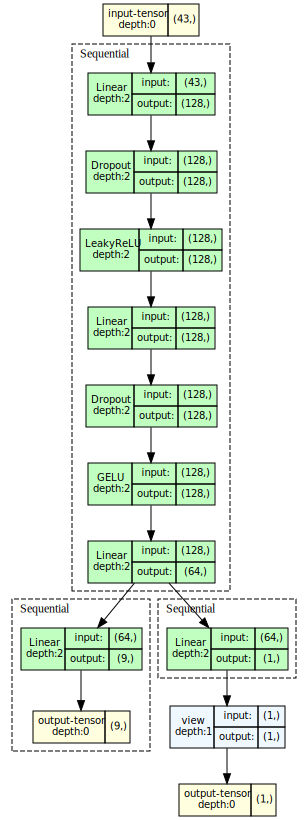

In [22]:
# Посмотрим какая модель у нас получилась
from torchview import draw_graph

model_graph = draw_graph(model, input_size=[cfg.num_features], expand_nested=True)
model_graph.visual_graph

# <center id="c7"> 🧌 Не боги неройнки обучают - запускаем Trainer </center>

<div class="alert alert-info">
    
Получаем точно такую же модельку, так что давайте обучим ее!
Для этого воспользуемся второй основной фишкой Lightning - `trainer`. Это класс, который управляет процессом обучения модели. Мы можем передать ему параметры и вызвать методы для обучения.

Вот как это делается:

1. Создаем экземпляр класса `Trainer`.
2. Устанавливаем параметры обучения.
3. Вызываем метод `fit` для обучения модели на тренировочном наборе данных.

Давайте создадим экземпляр класса `Trainer`, укажем параметры и вызовем метод `fit`.

In [25]:
trainer = Trainer(
    max_epochs=cfg.epochs, 
    log_every_n_steps=1,log_every_n_steps
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# <center id="c8"> 🩺 Отладка + Profiler 🎛 </center>

<div class="alert alert-info">
    
Также в `Lightning` есть удобная отладка модели - `Profiler` и `fast_dev_run`

* `Profiler` позволяет измерить время выполнения каждого слоя и функции, чтобы найти проблемы в модели
* `fast_dev_run` позволяет быстро проверить работу модели на тренировочном наборе данных и далее проверить на валидационной выборке. Он выполнит 1 эпоху для теста

In [28]:
trainer = Trainer(fast_dev_run=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [29]:
trainer.fit(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


<div class="alert alert-info">
    
Модель успешно прошла 1 эпоху обучения - теперь можем запускать на большее количество эпох!

<div class="alert alert-success">
    
Теперь запустим обучение с профайлером, чтобы понять, где в нашей архитектуре (или в нашем пайплайне) узкие места.

In [27]:
trainer = Trainer(
    profiler='simple',
    max_epochs=cfg.epochs,
    log_every_n_steps=10,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | mlp                      | Sequential       | 30.4 K | train
1 | regressor                | Sequential       | 65     | train
2 | classifier               | Sequential       | 585    | train
3 | regression_criterion     | MSELoss          | 0      | train
4 | classification_criterion | CrossEntropyLoss | 0      | train
----------------------------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                  

<div class="alert alert-info">
    
Данный `profiler` позволяет понять, где у вас стопорится модель - в какой функции, чтобы провести более подробную отладку можно использовать другие профайлеры отсюда: https://pytorch-lightning.readthedocs.io/en/2.2.0/pytorch/api_references.html#profiler

Данный `profiler` анализирует сколько каждая функция работала при обучении модели (в том числе служебные функции Lightning):
- Кол-во вызовов функции
- Общее затраченное время
- Процентная нагрузка

Полезно, когда обучаете сетку в несколько этапов и хотите найти какой этап работает медленне чем остальные.

<div class="alert alert-success">
Более детально с другими параметрами Trainer'a и метриками познакомимся в следующем уроке!

# <center id="c9"> 🍏 Результаты и выводы ✅
...

# <center id="c10"> 📝 Полезные ссылки </center>

<div class="alert alert-warning">

К сожалению, [сайт](https://lightning.ai/docs/pytorch/stable//index.html) фреймворка с официальной документацией не открывается для пользователей из РФ. Можно использовать VPN. На установке и использовании библиотеки это никак не сказывается.

Также есть другой ресурс с документацией, который открывается без VPN:

https://pytorch-lightning.readthedocs.io/en/2.5.0/pytorch/